In [1]:
#@title imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from matplotlib.collections import PatchCollection
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch
import os
%matplotlib inline

In [2]:
#@title data definition, currently load data
# @title String fields

create_data= 0 # @param {type:"integer"}

thesis_folder_path = "/content/drive/MyDrive/thesis"

def save_data(X, y):
  np.save(f"{thesis_folder_path}/2D_data/X_2_D_{len(X)}.npy", X)
  np.save(f"{thesis_folder_path}/2D_data/y_2_D_{len(y)}.npy", y)

def load_data(size):
  X = np.load(f"{thesis_folder_path}/2D_data/X_2_D_{size}.npy")
  y = np.load(f"{thesis_folder_path}/2D_data/y_2_D_{size}.npy")
  save_data(X, y)
  class_1 = X[:int(len(X) / 2)]
  class_2 = X[int(len(X) / 2):]
  return X, y, class_1, class_2

def create_data(size=40):
  """
  size should be divided by 10 and by 4
  """
  try:
    X, y, class_1, class_2 = load_data(size)
    print("loading old data")
    return X, y, class_1, class_2
  except:
    pass

  mean_1 = np.array([-1, 1]) * 4
  mean_2 = np.array([1, -1]) * 4
  mean_3 = np.array([1, 1]) * 4
  mean_4 = np.array([-1, -1]) * 4
  cov = np.eye(2) * 2

  b_1 = np.random.multivariate_normal(mean_1, cov, int(size / 4))
  b_2 = np.random.multivariate_normal(mean_2, cov, int(size / 4))
  b_3 = np.random.multivariate_normal(mean_3, cov, int(size / 4))
  b_4 = np.random.multivariate_normal(mean_4, cov, int(size / 4))


  class_1 = np.concatenate([b_1[:int(.9 * len(b_1))], b_2[:int(.9 * len(b_2))], b_3[int(.9 * len(b_3)):], b_4[int(.9 * len(b_4)):]])
  class_2 = np.concatenate([b_1[int(.9 * len(b_1)):], b_2[int(.9 * len(b_2)):], b_3[:int(.9 * len(b_3))], b_4[:int(.9 * len(b_4))]])

  # Concatenate the data and create labels (0 and 1 for two classes)
  X = np.vstack((class_1, class_2))
  y = np.hstack((np.zeros(len(class_1)), np.ones(len(class_1))))

  plt.scatter(class_1[:, 0], class_1[:, 1], s=10, label='Class 1')
  plt.scatter(class_2[:, 0], class_2[:, 1], s=10, label='Class 2')
  return X, y, class_1, class_2



if create_data == 1:
  create_data
  X, y, class_1, class_2 = create_data(size=40)
else:
  X, y, class_1, class_2 = load_data(size=40)

outlayers = np.concatenate([class_1[int(.9 * len(class_1)):], class_2[:int(.1 * len(class_2))]])


meshgrid_dict = {}
grid_added_size = 0.2
num_points = 0.01
trades_epsilon = 1.
grid_size = trades_epsilon + grid_added_size

for i, (x_, y_) in enumerate(outlayers):
    x_vals = np.arange(x_ - grid_size, x_ + grid_size , num_points)
    y_vals = np.arange(y_ - grid_size, y_ + grid_size , num_points)
    xx, yy = np.meshgrid(x_vals, y_vals)

    # Store the meshgrid in a dictionary
    if i < len(outlayers) / 2:
      c = 'blue'
    else:
      c = 'orange'
    meshgrid_dict[f"Point_{i+1}"] = (xx, yy, x_, y_, c)


# Creating a meshgrid for the entire feature space
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

meshgrid_dict["full"] = (xx, yy, 0, 0)



points = []
for key in meshgrid_dict.keys():
  if key != "full":
    xx, yy, x_, y_, c = meshgrid_dict[key]
    points.append((x_, y_))



(40, 24168)
(24168,)
[36 36 36 ... 22 22 22]


<ipython-input-3-e1584fb7328e>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


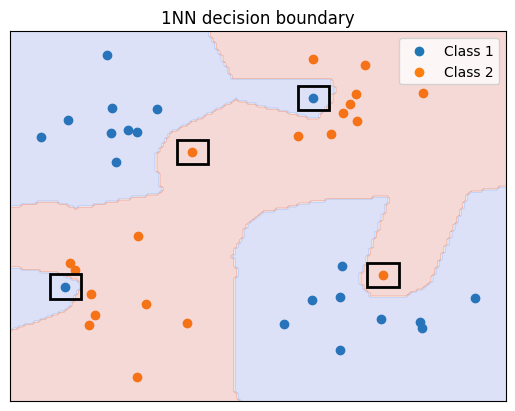

In [3]:
#@title 1NN ploting
class nn:

  def __init__(self, x, y):
    self.x = x.reshape(len(x), 1, -1)  # shape (samples, 1, 2)
    self.y = y  # shape (samples, )


  def predict(self, x_test):# shape (samples, 2)

    d = np.sqrt(np.sum((self.x - x_test.reshape(1, len(x_test), 2)) ** 2, axis=2))
    print(d.shape)
    nearest_neighbor_index = np.argmin(d, axis=0)
    print(nearest_neighbor_index.shape)
    print(nearest_neighbor_index)
    return self.y[nearest_neighbor_index]


nn_model = nn(X, y)

f, axes = plt.subplots(1, 1)
xx, yy, _, _ = meshgrid_dict["full"]

# Plotting the decision boundary
axes.scatter(class_1[:, 0], class_1[:, 1], label='Class 1')
axes.scatter(class_2[:, 0], class_2[:, 1], label='Class 2')


# Predicting for all points in the meshgrid
Z = nn_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


cmap = plt.cm.get_cmap('coolwarm')

# Plot decision boundary, plt.cm.bone
axes.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)
if points is not None:
    for square_center in points:
        square_side_length = trades_epsilon  # Set the side length of the square
        square = matplotlib.patches.Rectangle((square_center[0] - square_side_length / 2, square_center[1] - square_side_length / 2),
                            square_side_length, square_side_length, fill=False, edgecolor='black', linewidth=2)
        axes.add_patch(square)

plt.xticks([])
plt.yticks([])
plt.title('1NN decision boundary')
plt.legend()
plt.savefig("/content/drive/MyDrive/thesis/2D_data/1NN_decision_boundary.pdf")
plt.show()


In [4]:
#@title ploter function definition neural networks

def nn_ploter(net, xx, yy, plt_axes,class_1, class_2, c1=None, c2=None, squares=None):

  net.eval()
  with torch.no_grad():
    # Plotting the decision boundary
    plt_axes.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c=c1)
    plt_axes.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c=c2)

    # Predicting for all points in the meshgrid
    Z = net(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).to(torch.float32))
    Z = torch.argmax(Z, dim=1).numpy()
    Z = Z.reshape(xx.shape)

    # Plot decision boundary, plt.cm.bone
    cmap = plt.cm.get_cmap('coolwarm')
    plt_axes.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)
    try:
      plt_axes.set_xticks([])  # Hide x-axis ticks
      plt_axes.set_yticks([])  # Hide y-axis ticks
    except:
      plt_axes.xticks([])  # Hide x-axis ticks
      plt_axes.yticks([])  # Hide y-axis ticks

    if squares is not None:
        for square_center in squares:
            square_side_length = trades_epsilon  # Set the side length of the square
            square = matplotlib.patches.Rectangle((square_center[0] - square_side_length / 2, square_center[1] - square_side_length / 2),
                                square_side_length, square_side_length, fill=False, edgecolor='black', linewidth=2)
            plt_axes.add_patch(square)
  net.train()



        # plt_axes.add_collection(PatchCollection(squares_rec))


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0.9
0.9
0.9
0.9
0.9
0.9
0.925
0.925
0.925
0.925
epoch=500



<ipython-input-4-346628be45fc>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


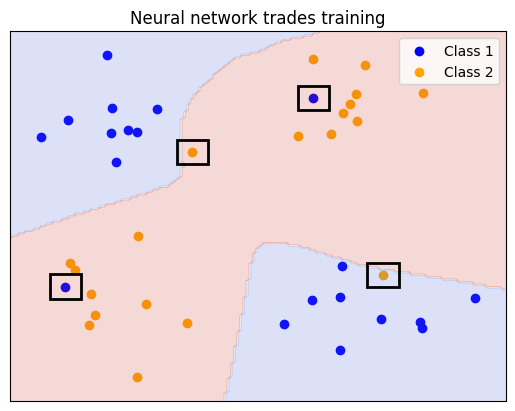

0.925
0.925
0.925
0.925
0.95
0.975
0.975
100% train accuarcy


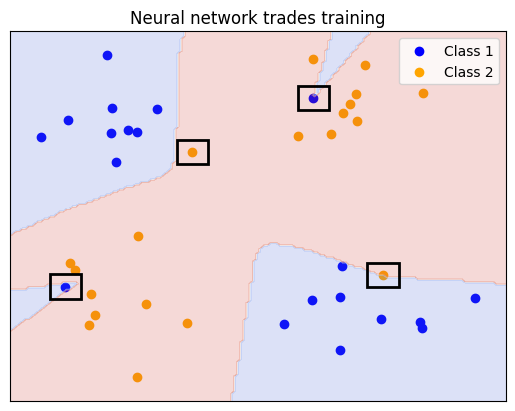

In [9]:

# @title neural network trades training
training_epochs = 1101 # @param {type:"integer"}
saving_frequency = 500 # @param {type:"integer"}
load_saved_model = 0 # @param {type:"integer"}
import torch.nn as nn

def squared_l2_norm(x):
    flattened = x.view(x.unsqueeze(0).shape[0], -1)
    return (flattened ** 2).sum(1)


def l2_norm(x):
    return squared_l2_norm(x).sqrt()


def trades_loss_r2(model,
                x_natural,
                y,
                optimizer,
                step_size=0.003,
                epsilon=0.031,
                perturb_steps=10,
                beta=6.0,
                distance='l_inf',
                verbose=False,
                critirion=None):


    # define KL-loss
    eps = 1e-8
    criterion_kl = nn.KLDivLoss(size_average=False)
    model.eval()
    if beta == 0:
        logits = model(x_natural)
        return  critirion(logits, y)
    batch_size = len(x_natural)
    # generate adversarial example
    x_adv = x_natural.detach() + 0.001 * torch.randn(x_natural.shape).detach()
    if distance == 'l_inf':
        for _ in range(perturb_steps):
            x_adv.requires_grad_()
            with torch.enable_grad():
                loss_kl = criterion_kl(F.log_softmax(model(x_adv), dim=1),
                                       F.softmax(model(x_natural), dim=1))
            grad = torch.autograd.grad(loss_kl, [x_adv])[0]
            x_adv = x_adv.detach() + step_size * torch.sign(grad.detach())
            x_adv = torch.min(torch.max(x_adv, x_natural - epsilon), x_natural + epsilon)

    elif distance == 'l_2':
        delta = 0.001 * torch.randn(x_natural.shape).detach()
        delta = Variable(delta.data, requires_grad=True)

        # Setup optimizers
        optimizer_delta = optim.SGD([delta], lr=epsilon / perturb_steps * 2)

        for _ in range(perturb_steps):
            adv = x_natural + delta

            # optimize
            optimizer_delta.zero_grad()
            with torch.enable_grad():
                loss = (-1) * criterion_kl(torch.clamp(F.log_softmax(model(x_adv), dim=1), min=eps),
                                       torch.clamp(F.softmax(model(x_natural), dim=1), min=eps))
            loss.backward()
            # renorming gradient
            grad_norms = delta.grad.view(batch_size, -1).norm(p=2, dim=1)
            delta.grad.div_(grad_norms.view(-1, 1))
            # avoid nan or inf if gradient is 0
            if (grad_norms == 0).any():
                delta.grad[grad_norms == 0] = torch.randn_like(delta.grad[grad_norms == 0])
            optimizer_delta.step()

            # projection
            delta.data.add_(x_natural)
            delta.data.clamp_(0, 1).sub_(x_natural)
            delta.data.renorm_(p=2, dim=0, maxnorm=epsilon)
        x_adv = Variable(x_natural + delta, requires_grad=False)
    else:
        x_adv = x_adv
    model.train()


    # zero gradient
    optimizer.zero_grad()
    # calculate robust loss
    logits = model(x_natural)
    loss_natural = F.cross_entropy(logits, y)
    res = model(x_adv)
    loss_robust = (1.0 / batch_size) * criterion_kl(F.log_softmax(res, dim=1) + eps,
                                                    F.softmax(logits, dim=1) + eps)

    loss = loss_natural + beta * loss_robust

    return loss



trades_net = Net()
TRADES_PATH = f"{thesis_folder_path}/2D_data/trades_net_{len(X)}.pth"
if os.path.exists(TRADES_PATH) and (load_saved_model == 1):
  trades_net.load_state_dict(torch.load(TRADES_PATH))
  print()
  print("loading already trained model")

else:
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(trades_net.parameters(), lr=0.001, momentum=0.94)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.9)

  for epoch in range(training_epochs):  # loop over the dataset multiple times
      sum=0
      for i, data in enumerate(data_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(torch.float32)
          labels = labels.to(torch.long)

          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = trades_net(inputs)


          loss = trades_loss_r2(model=trades_net,
                          x_natural=inputs,
                          y=labels,
                          optimizer=optimizer,
                          step_size=0.03,
                          epsilon=trades_epsilon,
                          perturb_steps=10,
                          beta=6,
                          critirion=None)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          with torch.no_grad():
            sum += (torch.argmax(outputs, dim=1) == labels).sum().item()
      scheduler.step()
      if epoch % 50 == 0 and epoch > 0:
          print(sum / len(data_loader.dataset))
      if epoch % saving_frequency == 0 and epoch > 0:

        print(f"{epoch=}", end="\n\n")
        fig, ax = plt.subplots()
        xx, yy, x_, y_ = meshgrid_dict["full"]
        nn_ploter(trades_net, xx, yy, ax, class_1, class_2, "blue", "orange", squares=points)
        plt.title(f'Neural network trades training')
        plt.legend()
        plt.show()
      if sum == len(data_loader.dataset):
        print("100% train accuarcy")
        break
  torch.save(trades_net.state_dict(), TRADES_PATH)
fig, ax = plt.subplots()
xx, yy, x_, y_ = meshgrid_dict["full"]
nn_ploter(trades_net, xx, yy, ax, class_1, class_2, "blue", "orange", squares=points)
plt.title(f'Neural network trades training')
plt.legend()
plt.savefig(f"/content/drive/MyDrive/thesis/2D_data/NN_trades_decision_boundary.pdf")



<ipython-input-4-346628be45fc>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


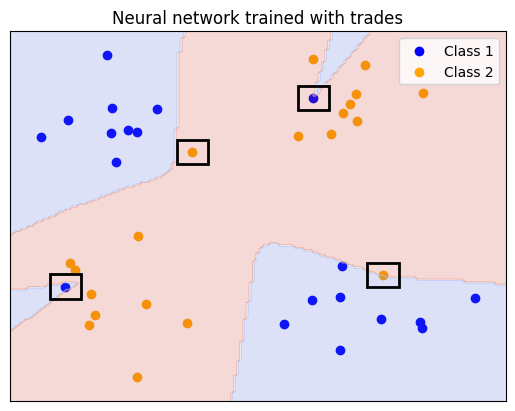

In [11]:
# @title trades neural network training main plot
fig, ax = plt.subplots()
xx, yy, x_, y_ = meshgrid_dict["full"]
nn_ploter(trades_net, xx, yy, ax, class_1, class_2, "blue", "orange", squares=points)
plt.title(f'Neural network trained with trades')
plt.legend()
plt.savefig(f"/content/drive/MyDrive/thesis/2D_data/NN_trades_decision_boundary.pdf")
plt.show()

<ipython-input-4-346628be45fc>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


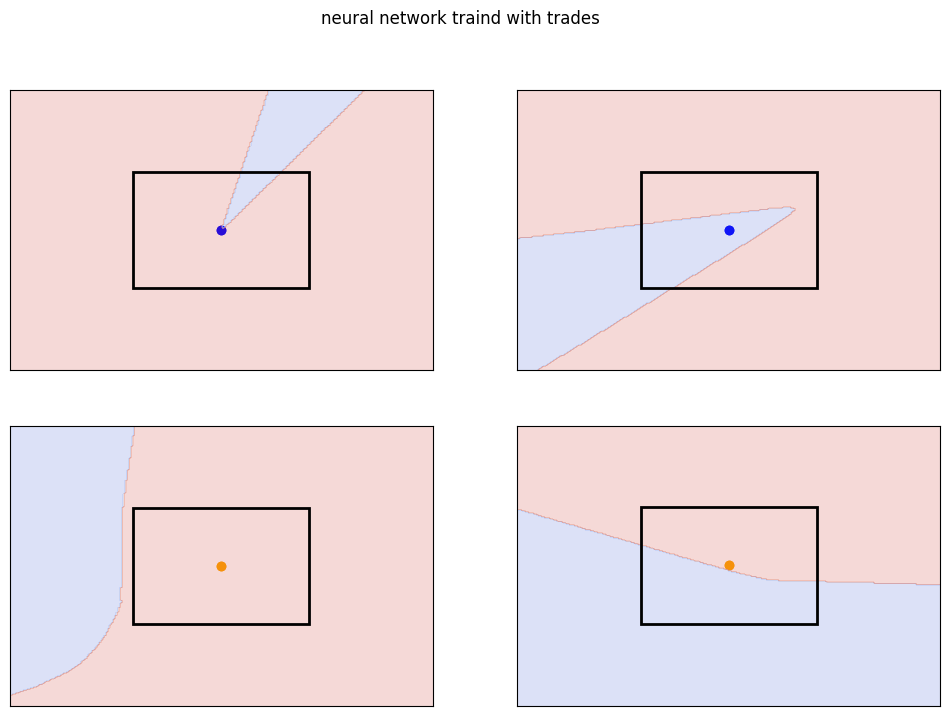

In [12]:
# @title trades neural network area around outlayers
columns = 2
fig, axs = plt.subplots(2, columns, figsize=(12, 8))
j = 0
for key in meshgrid_dict.keys():
  if key != "full":
    xx, yy, x_, y_, c = meshgrid_dict[key]
    c_1 = c_2 = np.array([[x_, y_]])
    i = j % columns
    k = int(j / columns)
    nn_ploter(trades_net, xx, yy, axs[k, i], c_1, c_2, c, c, squares=[(x_, y_)])
    j += 1

fig.suptitle(f'neural network traind with trades')
plt.show()